##### Program Design

### Folder Heirarchy

```
project
│   README.md
|   markdown-cheatsheet-online.pdf
│   HRTF_Estimation.ipynb    
|
│
└───Audio_devtest   #to test file iteration + processing not at-scale
│   │   file011.txt
|   │   file012.txt
│   └───MOS_test
│       │   file111.txt
│   
└───otherFolders
    │   file021.txt
```

### Logical Flow
1. Generate Database
    1. Generate Annotated Database (ambi_DB) of Ambisonic Representations of MongoDB Soundsources
    2. Obtain multiple HRTFs (HRTF_DB), annotated
    3. Create Secondary Annotated Database (main_DB) by convolving each in ambi_DB with each in HRTF_DB
2. Obtain MOS
    1. for each in main_DB
        1. Obtain 1 MOS for each in HRTF_DB
        2. Compare MOS values 
            a. search for hyperparameters that yield strong correlations
        3. Determine used HRTF for this from main_DB
3. Analysis + Discussion

## MOS Calculation

For one processed HRIR$(\alpha, \varphi)$ and test set of HRIRs indexed by $(\theta,\phi)$

Transform each into freq domain (fft)
log scale (magnitude dB)

Compare each processed HRIR$(\alpha, \varphi)$ to every in test set HRIR$(\theta,\phi)$ 
via both Elastic-Net Regression and Jensen-Shannon Distance

### Elastic-Net Regression (EN)

$\hat{\beta} = argmin_\beta||\textbf{y}- \textbf{X}\beta||^2 + \delta||\beta||^2 + \lambda||\beta||_1$

where: 
- **y** is the processed signal, 
- **X** is a matrix where each column is one HRIR from test set HRIR(θ,ϕ)
- $\beta$ is vector of coefficients produced by fitting the model
- "L2 norm" is defined as $||n||^2 = \sqrt{(|a|^2 + |b|^2)}$
    - where $n = (a, b)$ 
- δ is the L2 norm shrinkage parameter

- "L1 norm" is defined as $||n||_1 = |a| + |b|$
    - where $n = (a, b)$     
- λ is the L1 norm shrinkage parameter
    
and:
- $\hat{\beta}$ is the returned vector of coefficients, representing load on each predictor from test HRIR$(\theta,\phi)$ to reproduce the input response vector of HRIR$(\alpha, \varphi)$.

### Jenson-Shannon Distance (JSD)

Bounded and symmertical Kullback-Leibler (KL) divergence, measurement of similairty between two distributions. 

Computes the distance between the processed HRIR and all in test set. Lower values indivate statistically similar distributions, JSD of zero being identical. 

$JSD(P||T) = \sqrt{\frac{1}{2}[KL(P||\frac{P+T}{2}) + KL(T||\frac{P+T}{2})]}$

where: 
- $KL(P||T) = \sum(P(x)\frac{P(x)}{T(x)})$
- $P$ is the processed HRIR response
- $T$ is every member of Test HRIR set

### E-N distance computation

After computing EN distance between processed response signal HRIR$(\alpha, \varphi)$ and every member of the test set HRIR$(\theta,\phi)$, the returned $\hat{\beta}$ coefficients are indeced by \theta and \phi. 

Centroid + StdDev of $\hat{\beta}$ coefficients are of interest, as wel as angular distance from computed centroid to intended rendering position. Centroid must be calculated by first shifting distribution to center of image. 

**MOS-1** is the angular distance of computed centroid -> intended location

**MOS-2** is the std deviation of $\hat{\beta}$ coefficients as diffuse estimator

### JSD computation

JSD computed between processed HRIR$(\alpha, \varphi)$ and all in computed HRIR$(\theta,\phi)$, each value subtracted from 1 and plotted along azimuth + elevation axes. 

Angular Distance Map (ADM) is computed distance between intended location + every other location. ADM normalized between 0-1. 

**MOS-3** value at the index of ADM primary return index (highest coefficient value) of the JSD. Smaller MOS-3, more accurate rendering. 

**MOS-4** sum of all JSD coefficients multiplied by corresponding ADM values. Smaller MOS-4: more compact image. 

In [1]:
## Imports

import numpy as np
import librosa
import scipy.signal
import IPython.display as ipd
import sys
import os
import soundfile as sf

from sklearn.linear_model import ElasticNet as EN
from sklearn.linear_model import ElasticNetCV
from sklearn.datasets import make_regression
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics.pairwise import haversine_distances

import matplotlib.pyplot as plt
import colorcet as cc
import math

from scipy import ndimage
from scipy.spatial import distance
from math import pi as pi

import MOS_utilities as util

/Users/danielbraunstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def read_in_HRTF(folderpath, filetype=".wav", verbose=False):

    '''
    Reads in an HRTF from file into a 72-by-15 array of stereo impulse responses
    
    HRTF Ele Positions(12): -75, -60, -45, -30, -15, 0, 15, 30, 45, 60, 75, 90
         Azi Positions(72): 0:355[::5]
    
    
    Parameters
    ----------
        folderpath (string) : 
        
        
        filetype (string) : which type of HRTF file this function will look for, 
            currently only working with .wav, but planning to extend to .sofa.
        
        "WAV" will search for .wav files, located in subfolder ##K_##bit
            filenaming convention is "azi_#,#_ele_#,#.wav"
            
            ##K is Sample Rate
            ##bit is bit depth
            Commas represent decimals, prepend (-) if negative.
            e.g. 15 deg azi, -17.3 deg ele = "azi_15,0_ele_-17,3.wav"
        
        "sofa" will search for .sofa files
            filenaming convention is "D#_##K_##bit_###tap_FIR_SOFA.sofa"
            
            D# is HRTF subject no. (SADIE II database)
            ##K is Sample Rate
            ##bit is bit depth
            ###tap is FIR length in samples
            e.g. "D2_48K_24bit_256tap_FIR_SOFA.sofa"

    Returns
    -------
    
        HRTF_out (np.ndarray, shape(72,1)) : 
    '''
    
    HRTF_out = np.ndarray((72, 11, 2, 256))
    
    if(verbose==True):
        print("HRTF Shape:", HRTF_out.shape)

    start_az = 0;
    start_el = -75;
    
    # azimuth and elevation increments of 5 and 15 degrees, respectively
    az_inc = 5;
    el_inc = 15;
    
    # number of azimuth and elevation measurements
    num_azi = 72;
    num_ele = 11;
    
    for az_idx in range(0, num_azi):
        for el_idx in range(0, num_ele):
            curr_az = start_az + int(az_idx * az_inc);
            curr_el = start_el + int(el_idx * el_inc);
            
            filename = folderpath + "azi_{:.1f}_ele_{:.1f}".format(curr_az, curr_el)\
                .replace('.',',') + ".wav";
            
            y, sr = librosa.load(filename, sr=None, mono=False);
            HRTF_out[az_idx, el_idx] = y;
    
    return HRTF_out, sr

In [15]:
def new_IR_generation(audiofile, IR):
    '''
    Create a new IR through deconvolving audio signals after digital signal processing
    
    
    Parameters
    ----------
    audiofile : str
        processed audio signal to be deconvolced
    
    IR : str
        impulse response used to deconvolve signal
        

    Returns
    -------
    new_IR : np.array, shape (n,2) 
        new IR representing the digital signal processing 
    
    '''
    
    processed, fs = librosa.load(audiofile, sr=None, mono=False)
    original, fs = librosa.load(IR, sr=None, mono=False)
    
    #take FFT of both signals
    processedFFT = np.fft.fft(processed)
    originalFFT = np.fft.fft(original)
    
    #divide the two frequency complex vectors
    newFFT = processedFFT / originalFFT
    
    #bring back to time domain
    newIR = np.fft.ifft(newFFT)
    
    #cast to real numbers
    newIR = np.real(newIR)
    
    return newIR

In [4]:
def prepare_HRTF(test_HRTF):
    '''
    Parameters
    ----------
    convolved_signal : np.ndarray [shape=(2,n)]
    
    test_HRTF : np.ndarrray [shape=(72, 11, 2, 256)]

    Returns
    -------
    
    db-scaled-fft 
    
    db-scaled-fft-of-HRTFs
    '''
    
    dB_HRTF = np.empty((test_HRTF.shape[0],test_HRTF.shape[1],test_HRTF.shape[2],int(test_HRTF.shape[3]/2)));
    
    for n in range (0, test_HRTF.shape[0]):
        for m in range (0, test_HRTF.shape[1]):
            dB_HRTF[n,m] = util.dB_weighted_fft(test_HRTF[n,m])
        
    return dB_HRTF

In [5]:
@ignore_warnings(category=ConvergenceWarning)
def process_elastic_net(db_weighted_HRTF, HRIR=None, test_azimuth=None, test_elevation=None):
    
#     (azimuth, elevation, db_weighted_HRTF )
    
    
    # Get 1ch db-weighted-HRIR at chosen azi/ele if not provided
    if (HRIR == None):
        db_HRIR = util.get_HRIR(db_weighted_HRTF, test_azimuth, test_elevation, verbose=False)
        HRIR = db_HRIR[0];
    elif (azimuth == None and elevation == None):
        if (HRIR.nims==2):
            HRIR = HRIR[0];
        else:
            HRIR = HRIR;
    '''
    
    
    Parameters
    ----------
    
        

    Returns
    -------
    
    
    '''    

# Flatten input HRTF into a neat-o line for ease of EN, also split into mono
    flat_HRTF_L, flat_HRTF_R = util.flatten_HRTF_mono(db_weighted_HRTF)

# Train Regressor Model
    regr3 = ElasticNetCV(cv=5, random_state=0, max_iter=500, normalize=True)
    
    regr3.fit(flat_HRTF_L.T,  HRIR)

    coeff = regr3.coef_
    
# Once Trained, Generate a score chart based on fitted model of original HRTF dims
# currently ignoring stereo

    beta_scores = np.empty((db_weighted_HRTF.shape[0], db_weighted_HRTF.shape[1]),\
                           dtype=float);
    
    coeff = np.empty((db_weighted_HRTF.shape[0], db_weighted_HRTF.shape[1]),\
                           dtype=float);
    coeff_iter = 0;
    for azi_idx in range(0, db_weighted_HRTF.shape[0]):
        for ele_idx in range(0, db_weighted_HRTF.shape[1]):
#             proc_HRIR = util.get_HRIR(test_HRTF, (0 + (5 * azi_idx)), (-75 + (15 * ele_idx)),\
#                                 verbose=False)
#             proc_HRIR_L = proc_HRIR[0]
#             score = regr3.score(flat_HRTF_L.T, proc_HRIR_L)
#             beta_scores[azi_idx, ele_idx] = score;
            
            coeff[azi_idx, ele_idx] = regr3.coef_[coeff_iter];
            coeff_iter = coeff_iter + 1;
            
    
    return coeff

In [6]:
def center_azimuth(scores, azimuth_idx):
    '''
    Params:
    
    Centers data array so input HRTF(alpha, varphi) is centered in array
    
    -------
    scores : np.ndarray, shape=[n, m]
    
    azimuth : 
    
    Returns:
    --------
    shifted_scores : np.ndarray, [shape=(n, m)]
    
    xticklabels : np.ndarray, [shape=(n,)]
    '''
    
    
    if(azimuth_idx == 0):
        ## slice from 0:175 deg, -180:-5 and concatenate
        
        slice1 = scores[0:int(scores.shape[0]/2)];
        slice2 = scores[int(scores.shape[0]/2):scores.shape[0]];
        
        centered_scores = np.concatenate((slice2, slice1), axis=0);
        xticklabels = (np.arange(-180, 181, 20));
        
    elif(azimuth_idx > 0 and azimuth_idx < 36):
        # slice 1 is azi_idx:azi_idx + 35, slice 2 is azi_idx + 35:71, slice 3 is 0:azi_idx
        # cat(slice2, slice3, slice1)
        
        slice1 = scores[azimuth_idx:azimuth_idx + int(scores.shape[0]/2)]
        slice2 = scores[azimuth_idx + int(scores.shape[0]/2):scores.shape[0]];
        slice3 = scores[0:azimuth_idx];
         
        centered_scores=np.concatenate((slice2, slice3, slice1), axis=0);
        
        # ticks + labels follow similar logic, spaced 20 apart and ending +1 beyond array
        # azi_idx * 5 = azimuth degrees = offset and leftshift
        
        
        missing_ticks = int(azimuth_idx / 4)    
        xlabel_leftbound = int(5 * azimuth_idx) - 180;
    
        xticklabels =(np.arange(xlabel_leftbound, (191+20*missing_ticks), 20))
    
    
    elif(azimuth_idx > 36 and azimuth_idx <= 71):
        # slice 1 is azi_idx:71, slice 2 is 0:(azi_idx-36), slice 3 is azi_idx-35:azi_idx
        # cat(slice3, slice 1, slice 2)
        
        slice1 = scores[azimuth_idx:scores.shape[0]];
        slice2 = scores[0:azimuth_idx-int(scores.shape[0]/2)];
        slice3 = scores[azimuth_idx-int(scores.shape[0]/2):azimuth_idx];
         
        centered_scores=np.concatenate((slice3, slice1, slice2), axis=0);
        
        #number of ticks that will be 'pushed off' by the shift and need to be wrapped around
        missing_ticks = int((scores.shape[0] - azimuth_idx) / 4)
        np.arange(180-(20*missing_ticks), 191, 20);
        
        print(centered_scores.shape)
        
        #ticks beyond 180 = len - idx / 4
        xticklabels = np.concatenate((np.arange(180-(20*missing_ticks), 171, 20),\
                                      np.arange(-180, 191-(20*missing_ticks), 20)), axis=0);
        
    elif(azimuth_idx == 36):
         #azimuth == 36, aka 180deg, is alread centered. Do nothing.
        centered_scores = scores;
        xticklabels = (np.arange(0, 361, 20)); 
    else:
        print("Error: please enter an azimuth index value between 0 and ", scores.shape[0]-1);

    xticks = (np.arange(0.5, scores.shape[0]+1, 4))
    
    return centered_scores, xticks, xticklabels;


In [7]:
## Jensen-Shannon Distance
def process_JSD(db_weighted_HRTF, HRIR=None, test_azimuth=None, test_elevation=None):
    
    # Get db-weighted-HRIR at chosen azi/ele 
    if (HRIR == None):
        db_HRIR = util.get_HRIR(db_weighted_HRTF, test_azimuth, test_elevation, verbose=False)
        HRIR = db_HRIR[0];
    elif (azimuth == None and elevation == None):
        if (HRIR.nims==2):
            HRIR = HRIR[0];
        else:
            HRIR = HRIR;
    else:
        print("Error calling process_JSD. Please input an HRIR |OR| test azimuth/elevation.\n");
        return -1;
    
    JSD_map = np.zeros((db_weighted_HRTF.shape[0], db_weighted_HRTF.shape[1]))
    
    for azi_idx in range(0, db_weighted_HRTF.shape[0]):
        for ele_idx in range(0, db_weighted_HRTF.shape[1]):    
            JSD_p = util.NormalizeData(HRIR)
            JSD_q = util.NormalizeData(test_HRTF[azi_idx, ele_idx, 0])
            JSD_map[azi_idx, ele_idx] = 1 - scipy.spatial.distance.jensenshannon(JSD_p, JSD_q);   

    return JSD_map

## Angular Distance
def angular_distance_map(centered_data, x_index, y_index):
    
    out = np.zeros_like(centered_data);
    
    # Using the haversine 'great circle' distance, calculate shortest distance between two points on the unit circle
    for azi_idx in range(0, int(centered_data.shape[0])):
        for ele_idx in range(0, centered_data.shape[1]):
            
            # Multipliers are to counterbalance the index spacing to degrees
#             out[i,j] = scipy.spatial.distance.euclidean([i, j], [x_index, y_index])

            # convert from 2D index to degrees
            x = [-180 + (azi_idx*5), -75 + (ele_idx*15)]
            y = [-180 + (x_index*5), -75 + (y_index*15)]
            
            #convert to radians
            x_rad = [float(_) * pi / 180.0 for _ in x]
            y_rad = [float(_) * pi / 180.0 for _ in y]
            
            result= haversine_distances([x_rad, y_rad]);
            
            out[azi_idx,ele_idx] = result[0,1];
            
    return out

In [8]:
def get_MOS_1(azimuth_degrees, elevation_degrees, calculated_centroid):
# convert from 2D index to degrees
    x = [processed_azi, processed_ele]
    y = [-180 + (centroid[0]*5), -75 + (centroid[1]*15)]

    #convert to radians
    x_rad = [float(_) * pi / 180.0 for _ in x]
    y_rad = [float(_) * pi / 180.0 for _ in y]

    MOS_1 = (haversine_distances([x_rad, y_rad])[0,1]) * 180 / pi;
    
    return MOS_1

In [9]:
## Main Thingy



## Set your "Processed HRIR" azimuth and elevation (in degrees)
processed_azi = 0;
processed_ele = 0;

## Read in and prep the given HRTF

folderpath = "HRTFs/D1_HRIR_WAV/48K_24bit/";

HRTF, sr = read_in_HRTF(folderpath, ".wav")
test_HRTF = prepare_HRTF(HRTF)

## Turn HRIR into dB-weighted-HRIR (fft, nfft/2, the whole 9 yards)
# processed_HRIR = dB_weighted_fft(<YOUR_HRIR_HERE>)
processed_HRIR = util.dB_weighted_fft(test_HRTF[0, 5])

## Run the Elastic Net Regression to get necessary data for MOS-1 and MOS-2
#     Accepts either processed HRIR OR azimuth and elevation values. 
#     Azi/Ele will select from the test_HRTF to measure against itself
# USAGE:
#      en_coeff = process_elastic_net(test_HRTF, HRIR=processed_HRIR)
#      en_coeff = process_elastic_net(test_HRTF, test_azimuth=0.0, test_elevation=30.0)
en_coeff = process_elastic_net(test_HRTF, HRIR=None, test_azimuth=processed_azi, test_elevation=processed_ele);

## Convert "Processed Azi" into array index in order to center data
azimuth_idx = int(round(processed_azi / 5)) if (processed_azi >=0 and processed_azi < 360)\
    else int((360 - np.abs(processed_azi) % 360) / 5);

## Center and normalize data, generating respective xticks and labels for centered azimuth
centered_coeff, xticks, xticklabels = center_azimuth(en_coeff, azimuth_idx=azimuth_idx);
coeff_norm = util.NormalizeData(centered_coeff)

## Calculate centroid 
centroid = ndimage.measurements.center_of_mass(coeff_norm)

## MOS-1 - angular distance between intended location and calculated centroid
MOS_1 = get_MOS_1(azimuth_degrees=processed_azi, elevation_degrees=processed_ele, calculated_centroid=centroid);

## Calculate Angular Distance Map - used for MOS-2, MOS-3, MOS-4
ADM = angular_distance_map(coeff_norm, 36, 5);
ADM = util.NormalizeData(ADM) ## maybe?

## MOS-2, weighted standard deviation of EN coefficients, done by taking standard deviation
##     of ADM values, weighted by their corresponding coefficient values at (theta, phi)
ADM_p = np.multiply(coeff_norm, ADM);
avg = np.average(ADM_p, weights=coeff_norm);
variance = np.average((ADM_p-avg)**2, weights=coeff_norm)
MOS_2 = math.sqrt(variance) * 180/pi

## Calculate the Jensen-Shannon Distance
#     Accepts either processed HRIR OR azimuth and elevation values. 
#     Azi/Ele will select from the test_HRTF to measure against itself
# USAGE:
#      JSD = process_JSD(test_HRTF, HRIR=processed_HRIR)
#      JSD = process_JSD(test_HRTF, test_azimuth=0.0, test_elevation=30.0)
JSD = process_JSD(test_HRTF, test_azimuth=0.0, test_elevation=30.0)
JSD_centered, xticks, xticklabels = center_azimuth(JSD, azimuth_idx = 0)
JSD_norm = util.NormalizeData(JSD_centered)

## MOS_3 - the distance value of the ADM at the index of highest JSD value
MOS_3_x = np.argmax(JSD_norm.T.ravel()) % 72;
MOS_3_y = np.floor(np.argmax(JSD_norm.T) / 72);

## MOS_4 - average of product-wise multiplication of normalized JSD 
product_mat = np.multiply(JSD_norm, ADM)
MOS_4 = np.average(product_mat);

print("MOS-1: {:.2f}°, Angular Distance from intended azi,ele to calculated centroid".format(MOS_1));
print("MOS-2: {:.2f}°, Std. Deviation of Coefficients over sphere from EN Regression".format(MOS_2));
print("MOS-3: {:.2f}°, Value of Angular Distance Map(ADM) at index of largest JSD value".format(ADM[int(MOS_3_x), int(MOS_3_y)]));
print("MOS-4: {:.2f}, Average of all elements in ADM and JSD product matrix.".format(MOS_4));

MOS-1: 1.66°, Angular Distance from intended azi,ele to calculated centroid
MOS-2: 4.34°, Std. Deviation of Coefficients over sphere from EN Regression
MOS-3: 0.17°, Value of Angular Distance Map(ADM) at index of largest JSD value
MOS-4: 0.15, Average of all elements in ADM and JSD product matrix.


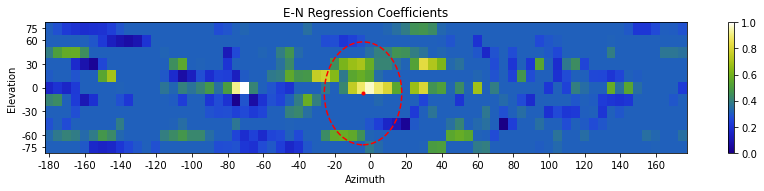

In [10]:
# Plotting E-N Regression
#-------------------------------------------------

fig = plt.figure(figsize=(14.4, 2.4))
ax = fig.add_subplot(111)

ax.set_title("E-N Regression Coefficients")
ax.set_xlabel("Azimuth")
# print("xt", xticks, "\nxtl", xticklabels)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

ax.set_ylabel("Elevation")
ax.set_yticks([0.5, 1.5, 3.5, 5.5, 7.5, 9.5, 10.5])
ax.set_yticklabels([-75, -60, -30, 0, 30, 60, 75])

pcm = ax.pcolor(coeff_norm.T, cmap=cc.cm.bgyw)
fig.colorbar(pcm)

# fig.colorbar(im, ax=ax)
plt.plot(centroid[0], centroid[1], '.r', label='centroid')
circle = plt.Circle((centroid[0], centroid[1]), MOS_2, color='red', fill=False, ls='--', lw=1.5)
ax.add_artist(circle)

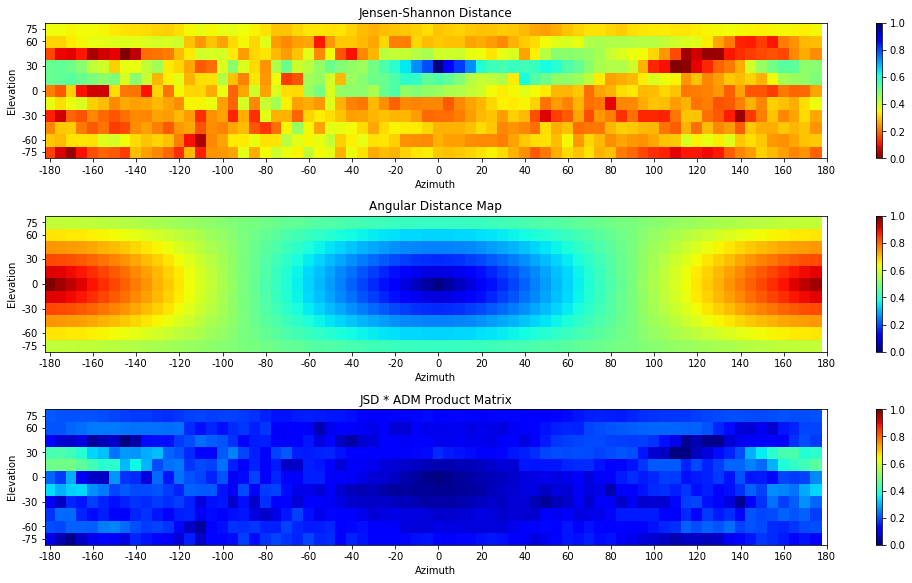

In [11]:
# Plotting JSD

fig = plt.figure(figsize=(14.4, 8.2));
ax1 = fig.add_subplot(311)
pcm1=plt.pcolor(JSD_norm.T, cmap='jet_r')
plt.colorbar(pcm1)
ax1.set_title("Jensen-Shannon Distance")

ax2 = fig.add_subplot(312)
pcm2=plt.pcolor(ADM.T, cmap='jet')
plt.colorbar(pcm2)
ax2.set_title("Angular Distance Map")

ax3 = fig.add_subplot(313)
pcm3=plt.pcolor(product_mat.T, cmap='jet', vmin=0, vmax=1)
plt.colorbar(pcm3)
ax3.set_title("JSD * ADM Product Matrix")

axs = [ax1, ax2, ax3]

for ax in axs:
    ax.set_xlabel("Azimuth")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    ax.set_ylabel("Elevation")
    ax.set_yticks([0.5, 1.5, 3.5, 5.5, 7.5, 9.5, 10.5])
    ax.set_yticklabels([-75, -60, -30, 0, 30, 60, 75])

plt.tight_layout()
plt.show()

In [12]:
def obtain_MOS (audiofile_path, HRTF_path):
    
    '''Get MOS (np.array) from Audiofile for Specific HRTF
    
    MOS = {MOS-1, MOS-2, MOS-3, MOS-4}
    
    Parameters
    ----------
    audiofile_path : str
        file name (*.wav) incl. path of stereo binaural signal
        
    HRTF_path: str
        HRTF folder including (*.wav) HRIRs for convolution
        
        

    Returns
    -------
    MOS : np.array, shape = (1, 4)
        outputs 4 MOS values for input audio file:
        
        MOS-1: (E-N) Localization Precision of Spectral Magnitude
        MOS-2: (E_N) Sptatial Variation / "Spread" of Spectral Magnitude
        MOS-3: (JSD) Localization Precision of Spectral Magnitude
        MOS-4: (JSD) Sptatial Variation / "Spread" of Spectral Magnitude
        

    
    
    
    '''


    
    pass


In [22]:
iteration1 = new_IR_generation('Chorus_Test_Files/Iteration1_48k_24bit.wav', 'Chorus_Test_Files/dry_vox_48k_24bit.wav')
iteration2 = new_IR_generation('Chorus_Test_Files/Iteration2_48k_24bit.wav', 'Chorus_Test_Files/dry_vox_48k_24bit.wav')
iteration3 = new_IR_generation('Chorus_Test_Files/Iteration3_48k_24bit.wav', 'Chorus_Test_Files/dry_vox_48k_24bit.wav')
iteration4 = new_IR_generation('Chorus_Test_Files/Iteration4_48k_24bit.wav', 'Chorus_Test_Files/dry_vox_48k_24bit.wav')
iteration5 = new_IR_generation('Chorus_Test_Files/Iteration5_48k_24bit.wav', 'Chorus_Test_Files/dry_vox_48k_24bit.wav')
iteration6 = new_IR_generation('Chorus_Test_Files/Iteration6_48k_24bit.wav', 'Chorus_Test_Files/dry_vox_48k_24bit.wav')
iteration7 = new_IR_generation('Chorus_Test_Files/Iteration7_48k_24bit.wav', 'Chorus_Test_Files/dry_vox_48k_24bit.wav')

In [20]:
ipd.Audio(iteration1, rate=48000)

(2, 576000)